In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import glob
import pylustrator

print(plt.style.available)
plt.style.use('seaborn-v0_8-talk')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [26]:
def set_high_dpi():
    plt.rcParams['figure.dpi'] = 400
    # plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['savefig.dpi'] = 400
    plt.rcParams['savefig.format'] = 'png'
    plt.rcParams['savefig.transparent'] = True

In [27]:
set_high_dpi()

In [28]:
LOG_PATH = "../logs/overhead/"
NU_SOCIALNET_LOG_PATH = LOG_PATH + "nu_socialnet/"

In [29]:
from dataclasses import dataclass
@dataclass
class Metric:
    label: str


In [30]:
data = []

In [31]:
def extract_data(match: str, embed: bool, debugger: str):
    # from 1 server to 7 servers setup
    for i in range(1, 8):
        files = glob.glob(NU_SOCIALNET_LOG_PATH + f"{match}.{i}.*")
        mops = 0
        avg_lat_sum = 0
        lat_p50_sum = 0
        lat_p90_sum = 0
        lat_p95_sum = 0
        lat_p99_sum = 0
        for file in files:
            with open(file, 'r') as f:
                lines = f.readlines()
                if lines:
                    # print(lines[-1].strip())
                    line_d = lines[-1].strip().split()
                    mops += float(line_d[0])
                    avg_lat_sum += int(line_d[1])
                    lat_p50_sum += int(line_d[2])
                    lat_p90_sum += int(line_d[3])
                    lat_p95_sum += int(line_d[4])
                    lat_p99_sum += int(line_d[5])
        avg_lat = avg_lat_sum / len(files)
        lat_p50 = lat_p50_sum / len(files)
        lat_p90 = lat_p90_sum / len(files)
        lat_p95 = lat_p95_sum / len(files)
        lat_p99 = lat_p99_sum / len(files)
        # print(f"i: {i}, mops: {mops}")
        data.append(
            {
                "servers": i,
                "mops": mops,
                "avg_lat": avg_lat,
                "lat_p50": lat_p50,
                "lat_p90": lat_p90,
                "lat_p95": lat_p95,
                "lat_p99": lat_p99,
                "embed": embed,
                "debugger": debugger
            }
        )

In [32]:
extract_data("DDB_DISABLE", False, "none")
extract_data("DDB_ENABLE", True, "none")
extract_data("gdb.DDB_DISABLE", False, "gdb")
extract_data("ddb.DDB_ENABLE", True, "ddb")

In [33]:
df = pd.DataFrame(data)
df.head()

,servers,mops,avg_lat,lat_p50,lat_p90,lat_p95,lat_p99,embed,debugger
0,1,0.685823,773.000000,103.666667,469.333333,920.000000,19112.666667,False,none
1,2,0.997933,598.666667,285.666667,976.333333,1536.333333,7942.000000,False,none
2,3,1.353621,442.333333,299.000000,962.000000,1379.000000,2482.333333,False,none
3,4,1.654394,360.666667,192.666667,660.666667,1099.666667,3883.666667,False,none
4,5,1.939352,308.000000,223.333333,653.666667,884.000000,1416.333333,False,none


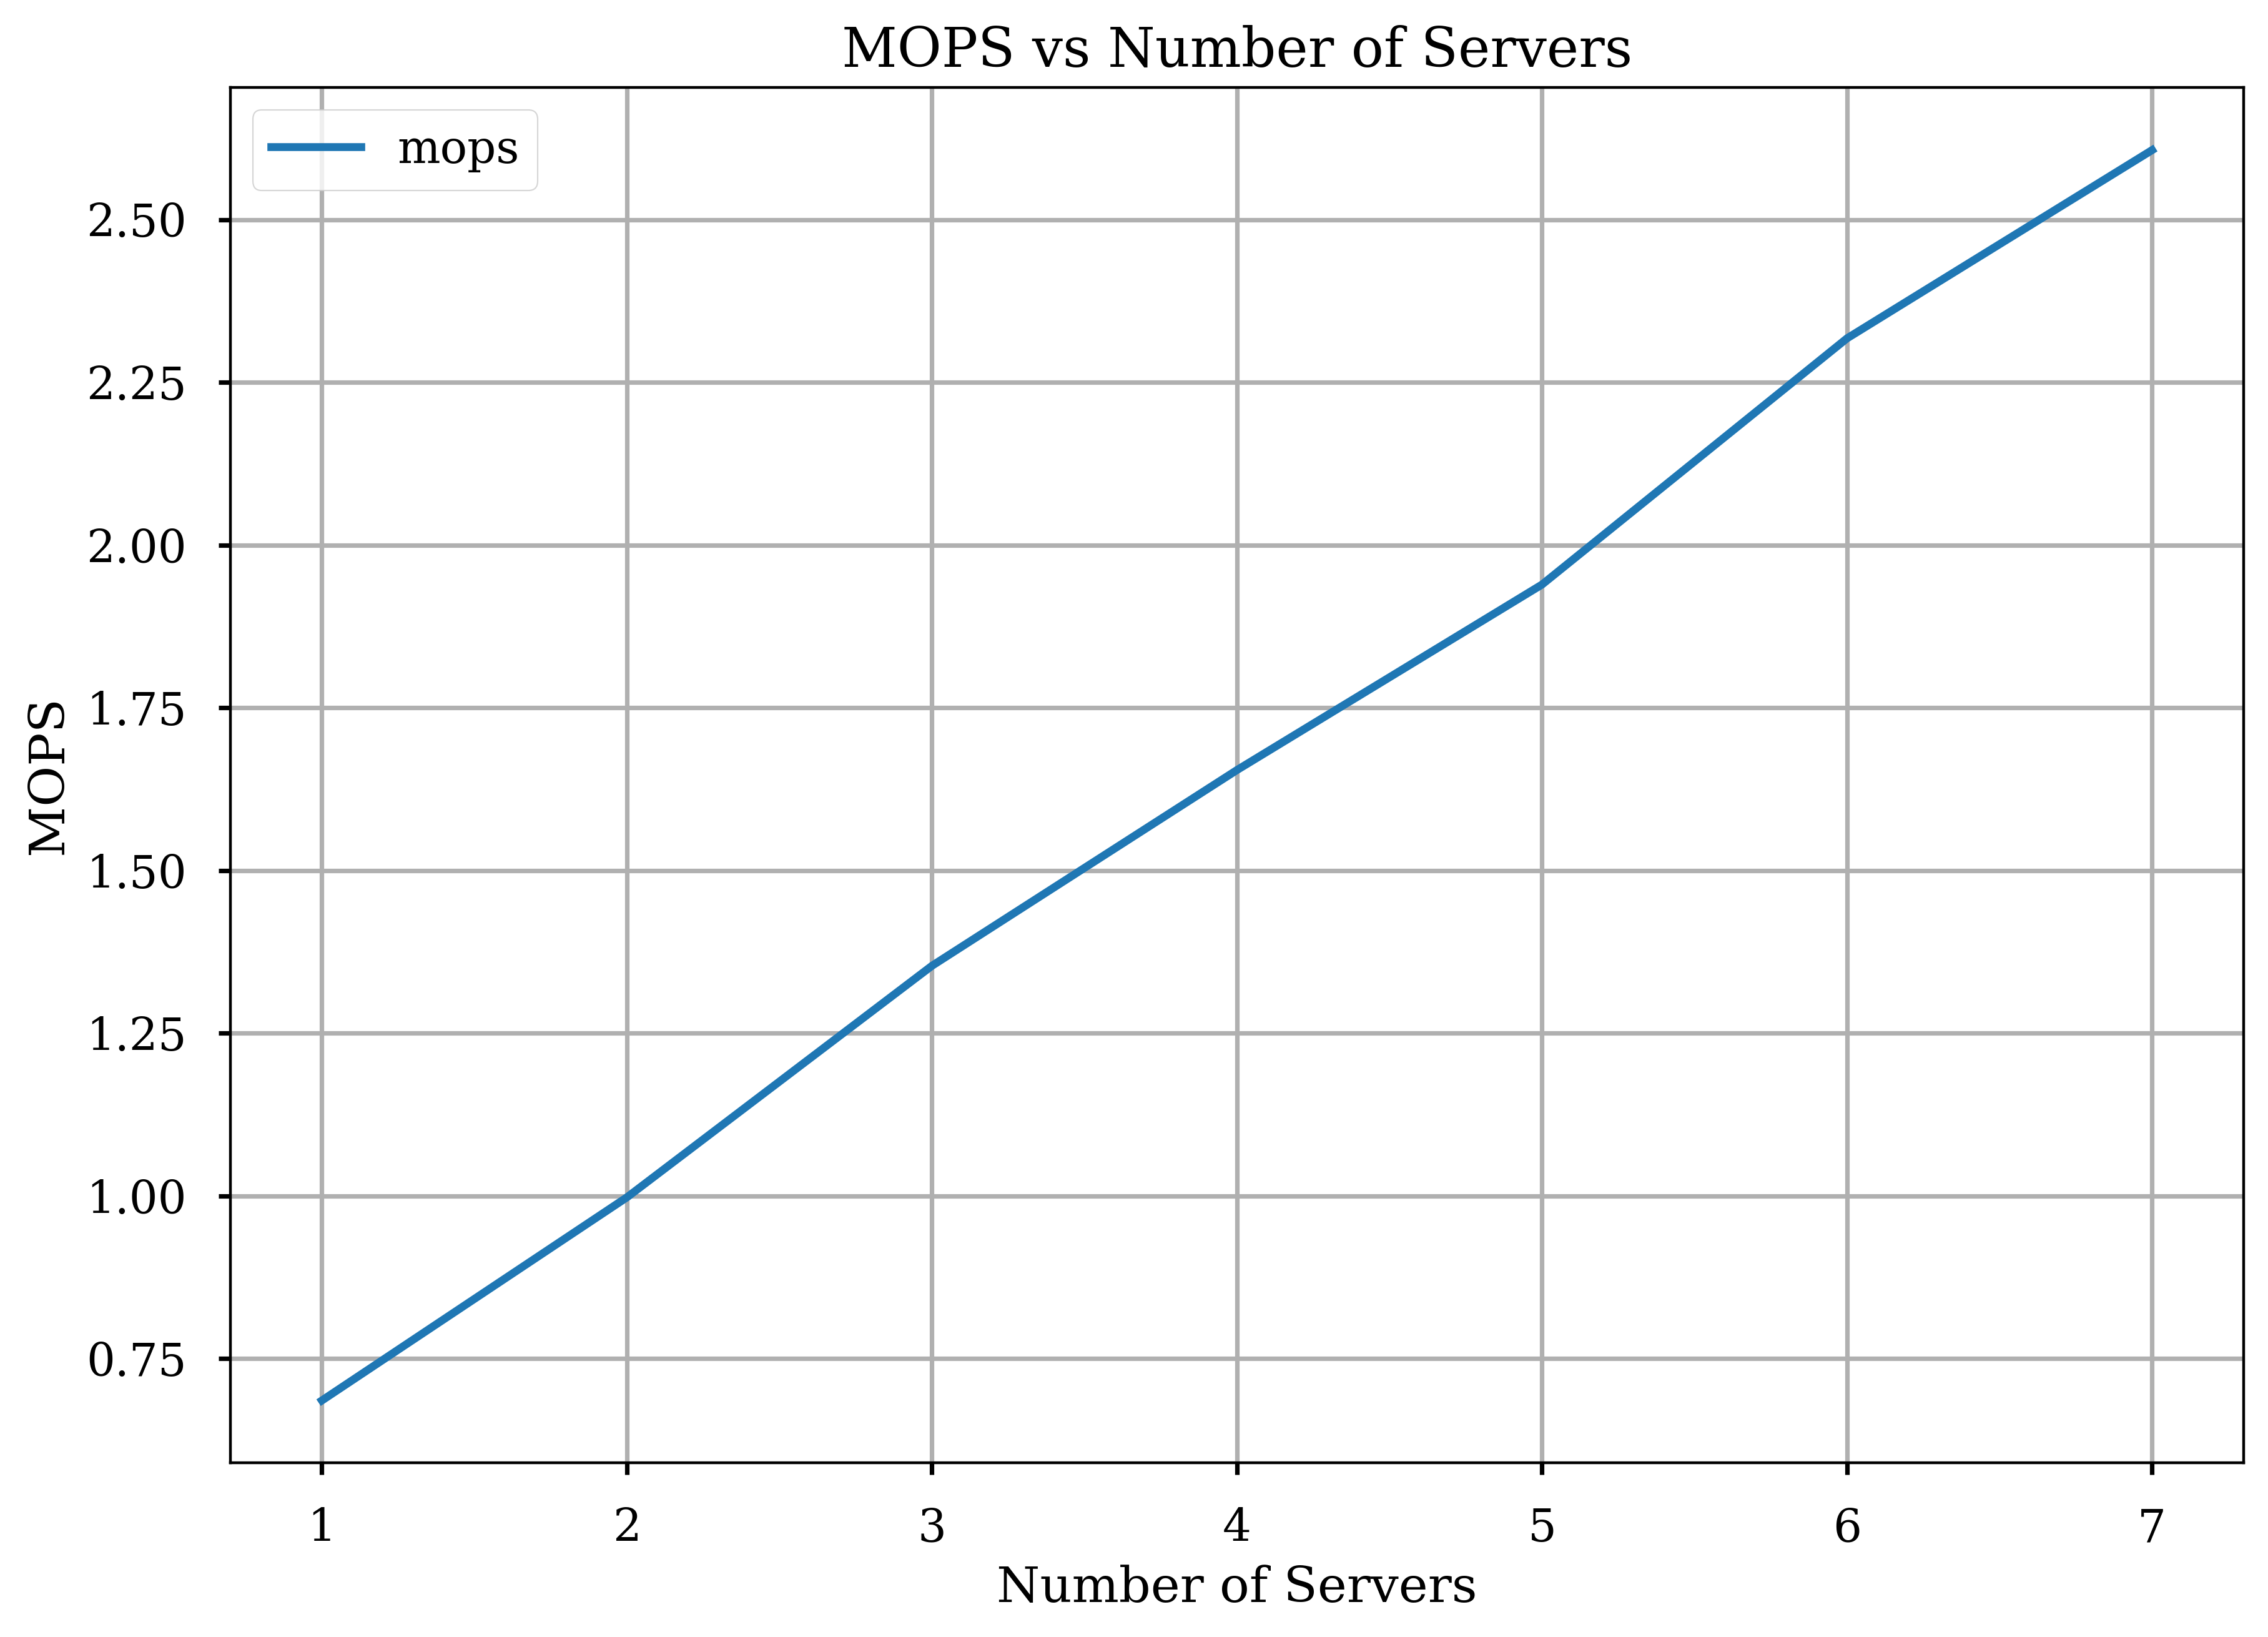

In [34]:
filtered_df = df.query('embed == False and debugger == "none"')
filtered_df
filtered_df.plot(x='servers', y='mops', kind='line')
plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.grid(True)
plt.show()

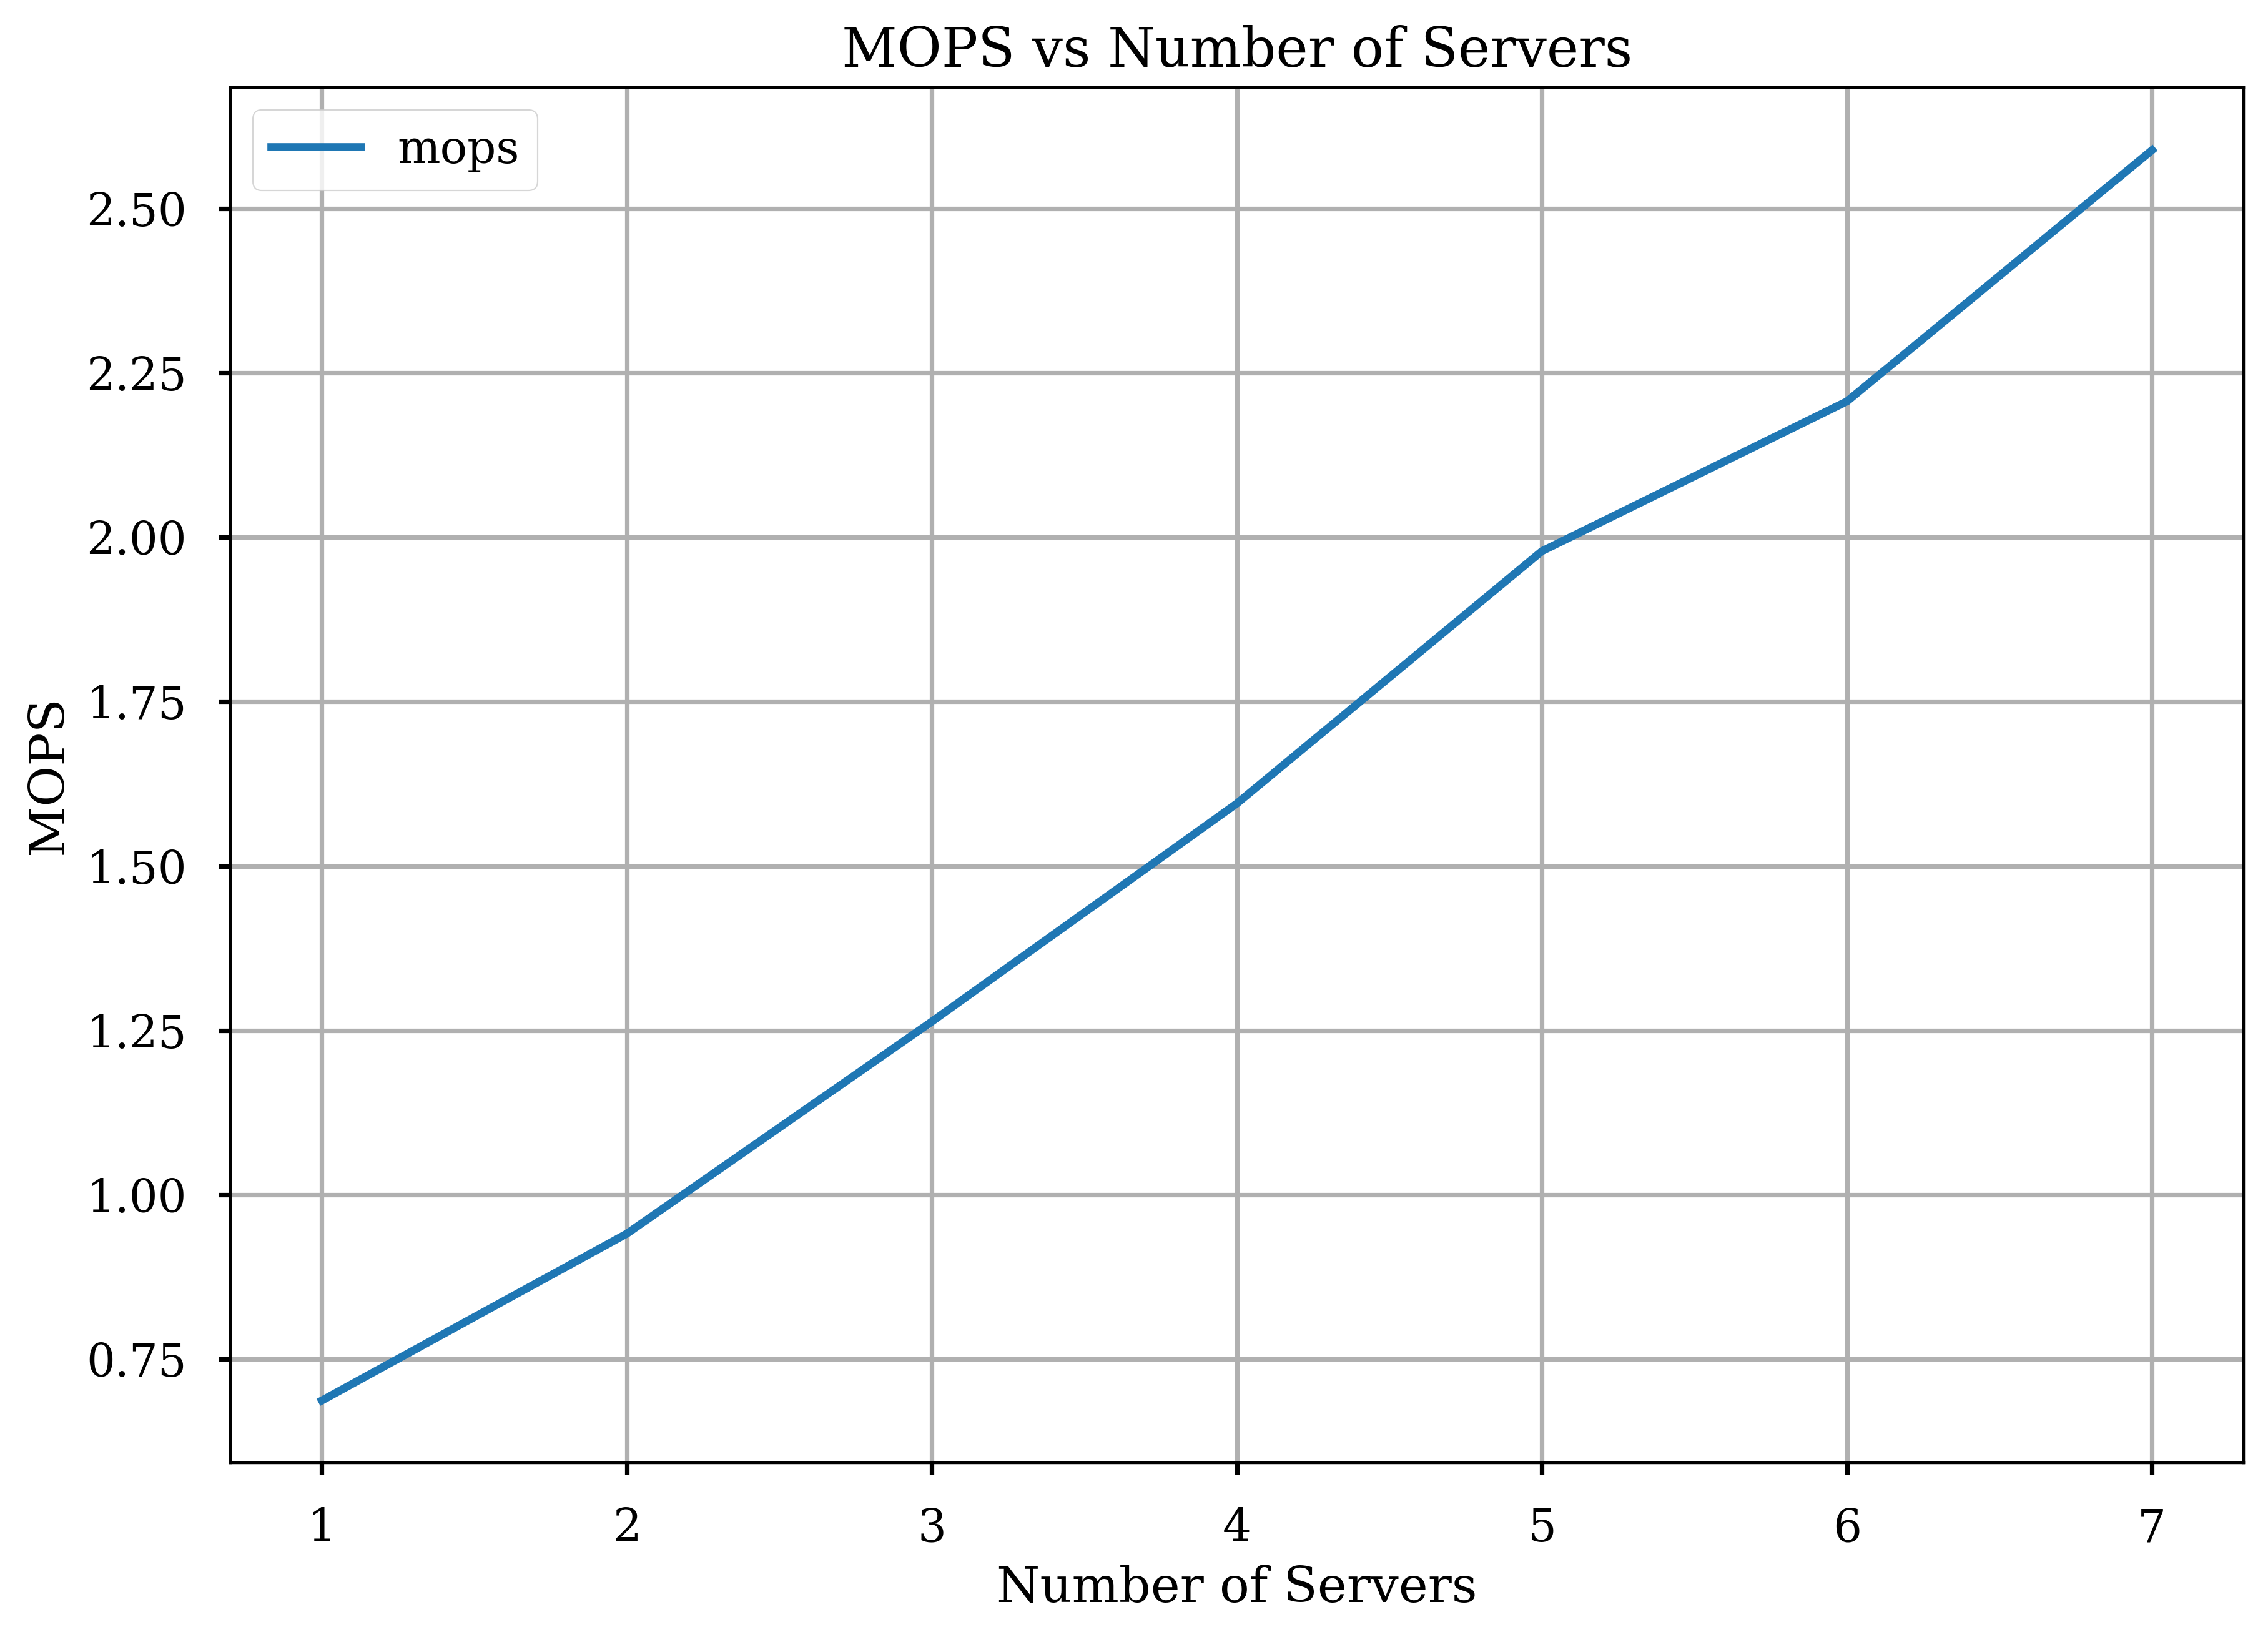

In [35]:
filtered_df = df.query('embed == True and debugger == "none"')
filtered_df
filtered_df.plot(x='servers', y='mops', kind='line')
plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.grid(True)
plt.show()

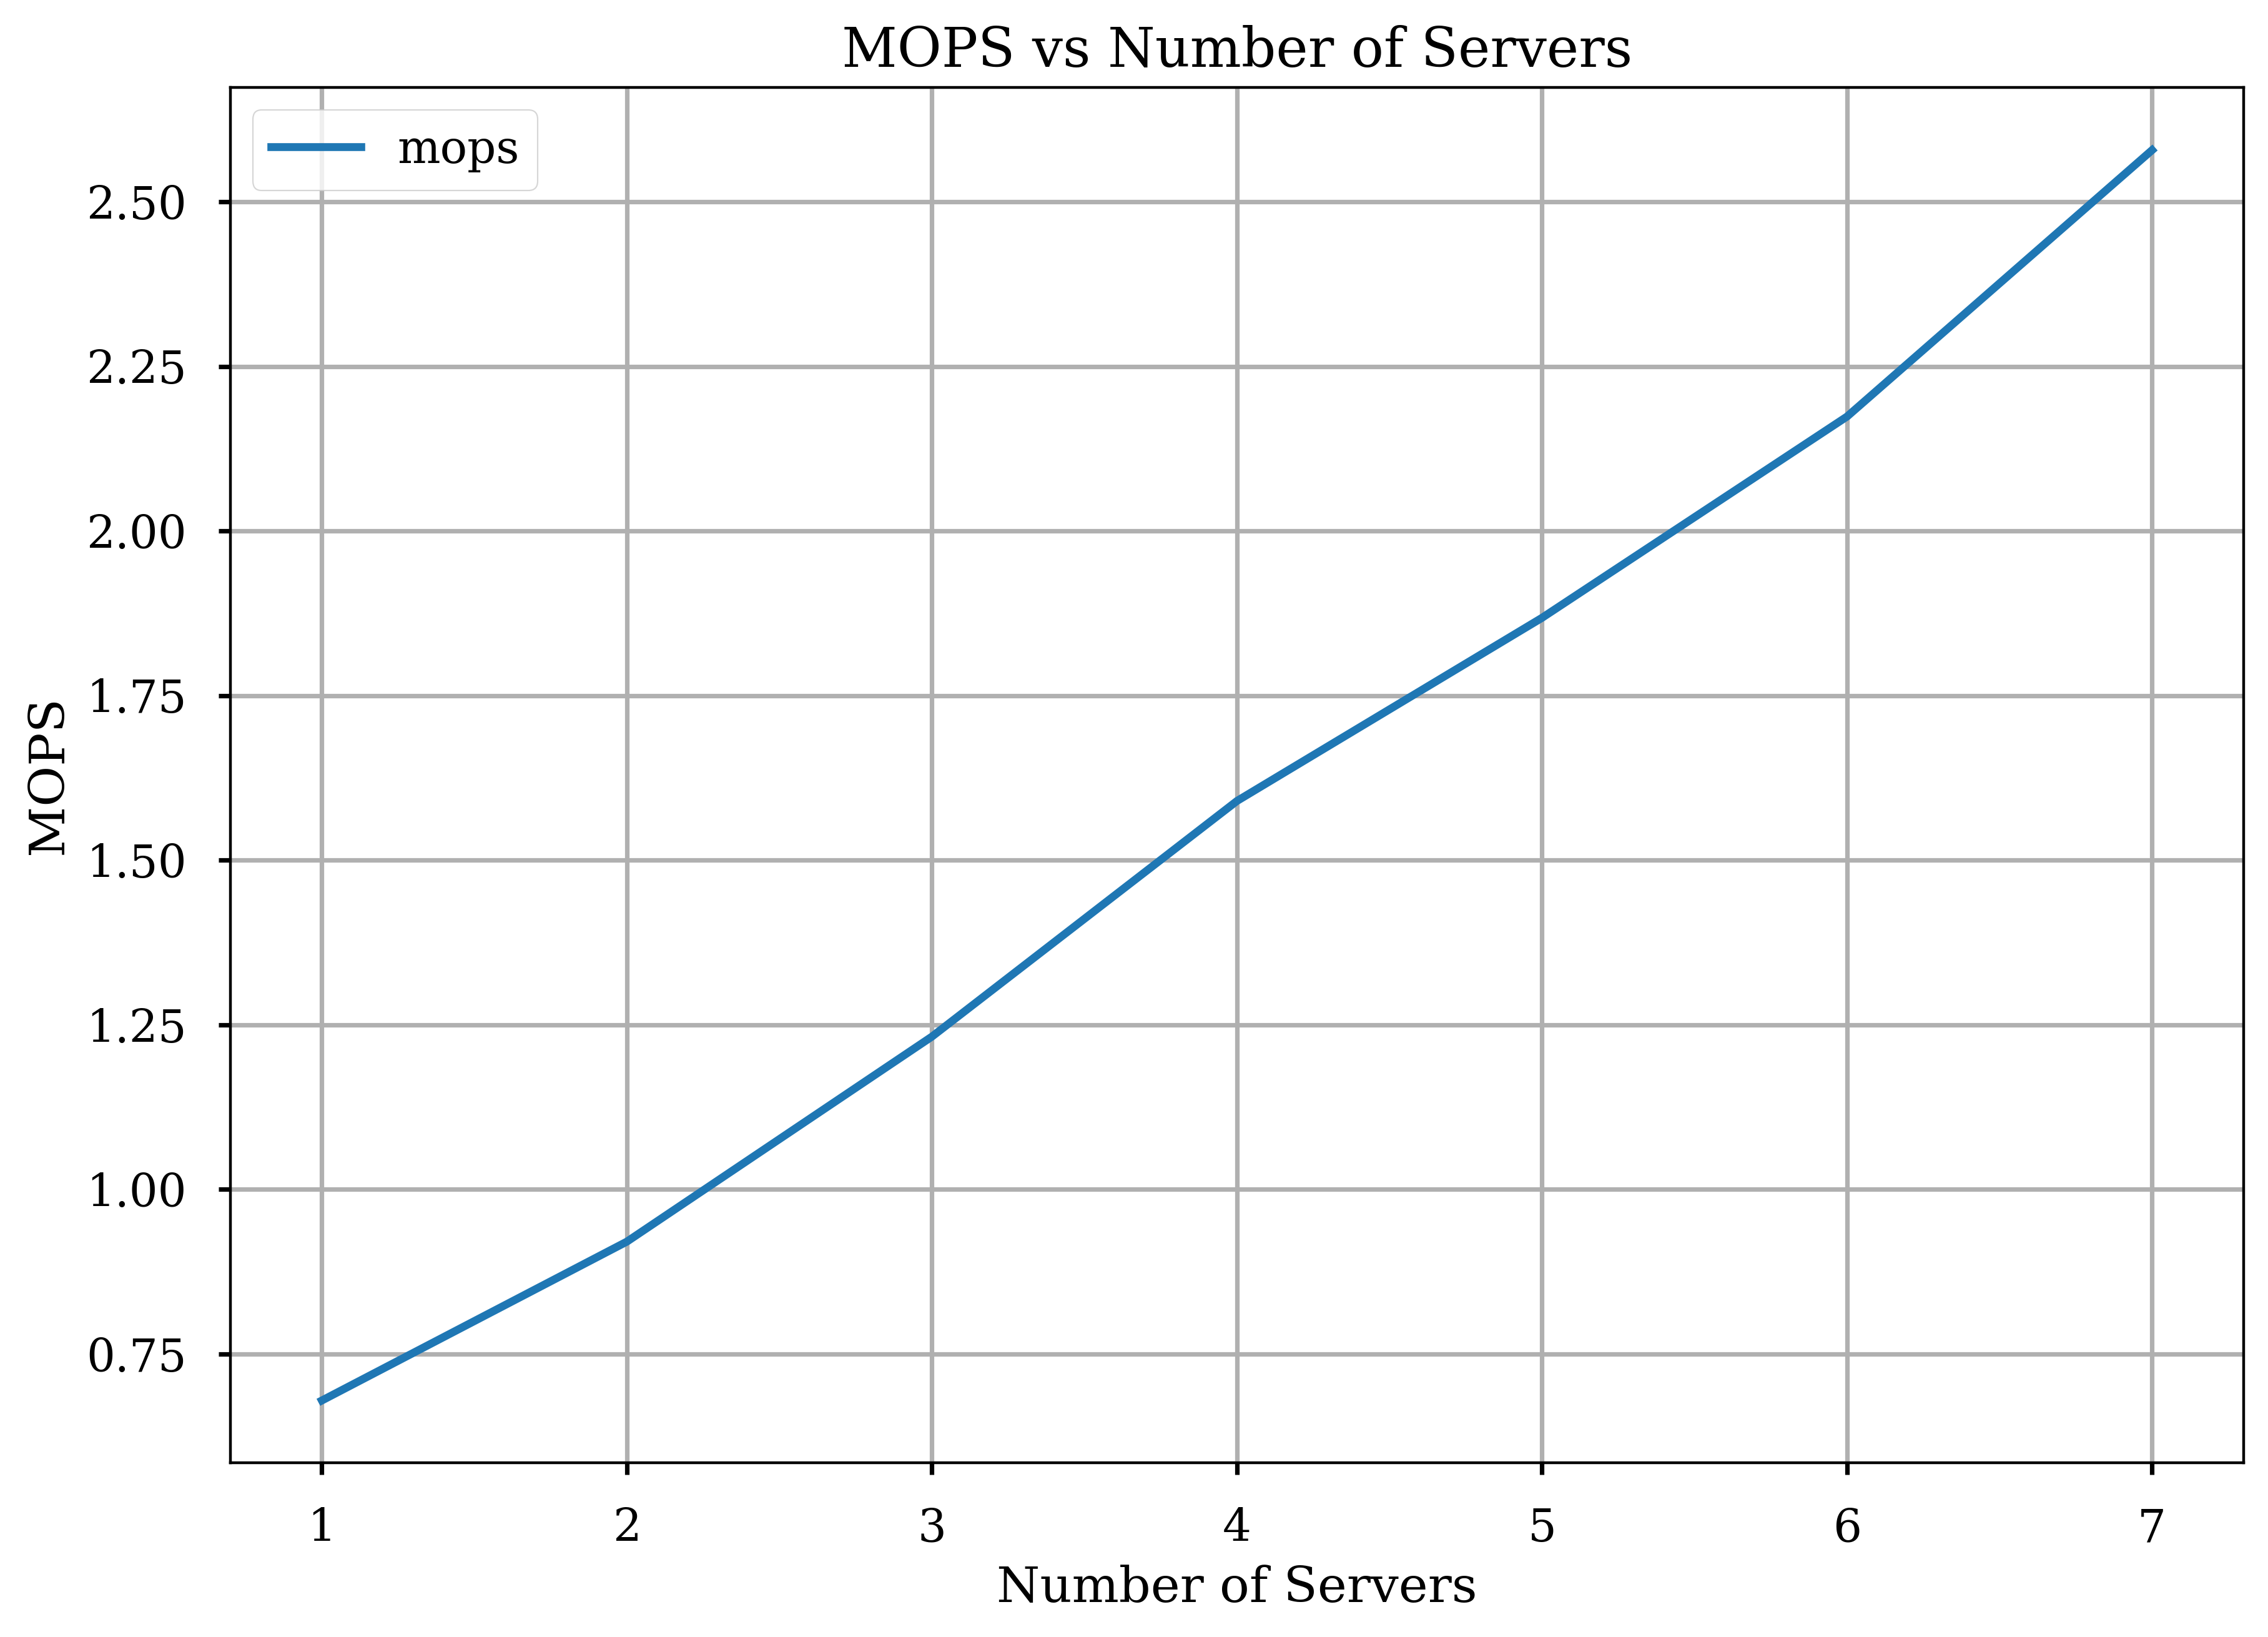

In [36]:
filtered_df = df.query('embed == True and debugger == "ddb"')
filtered_df
filtered_df.plot(x='servers', y='mops', kind='line')
plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.grid(True)
plt.show()

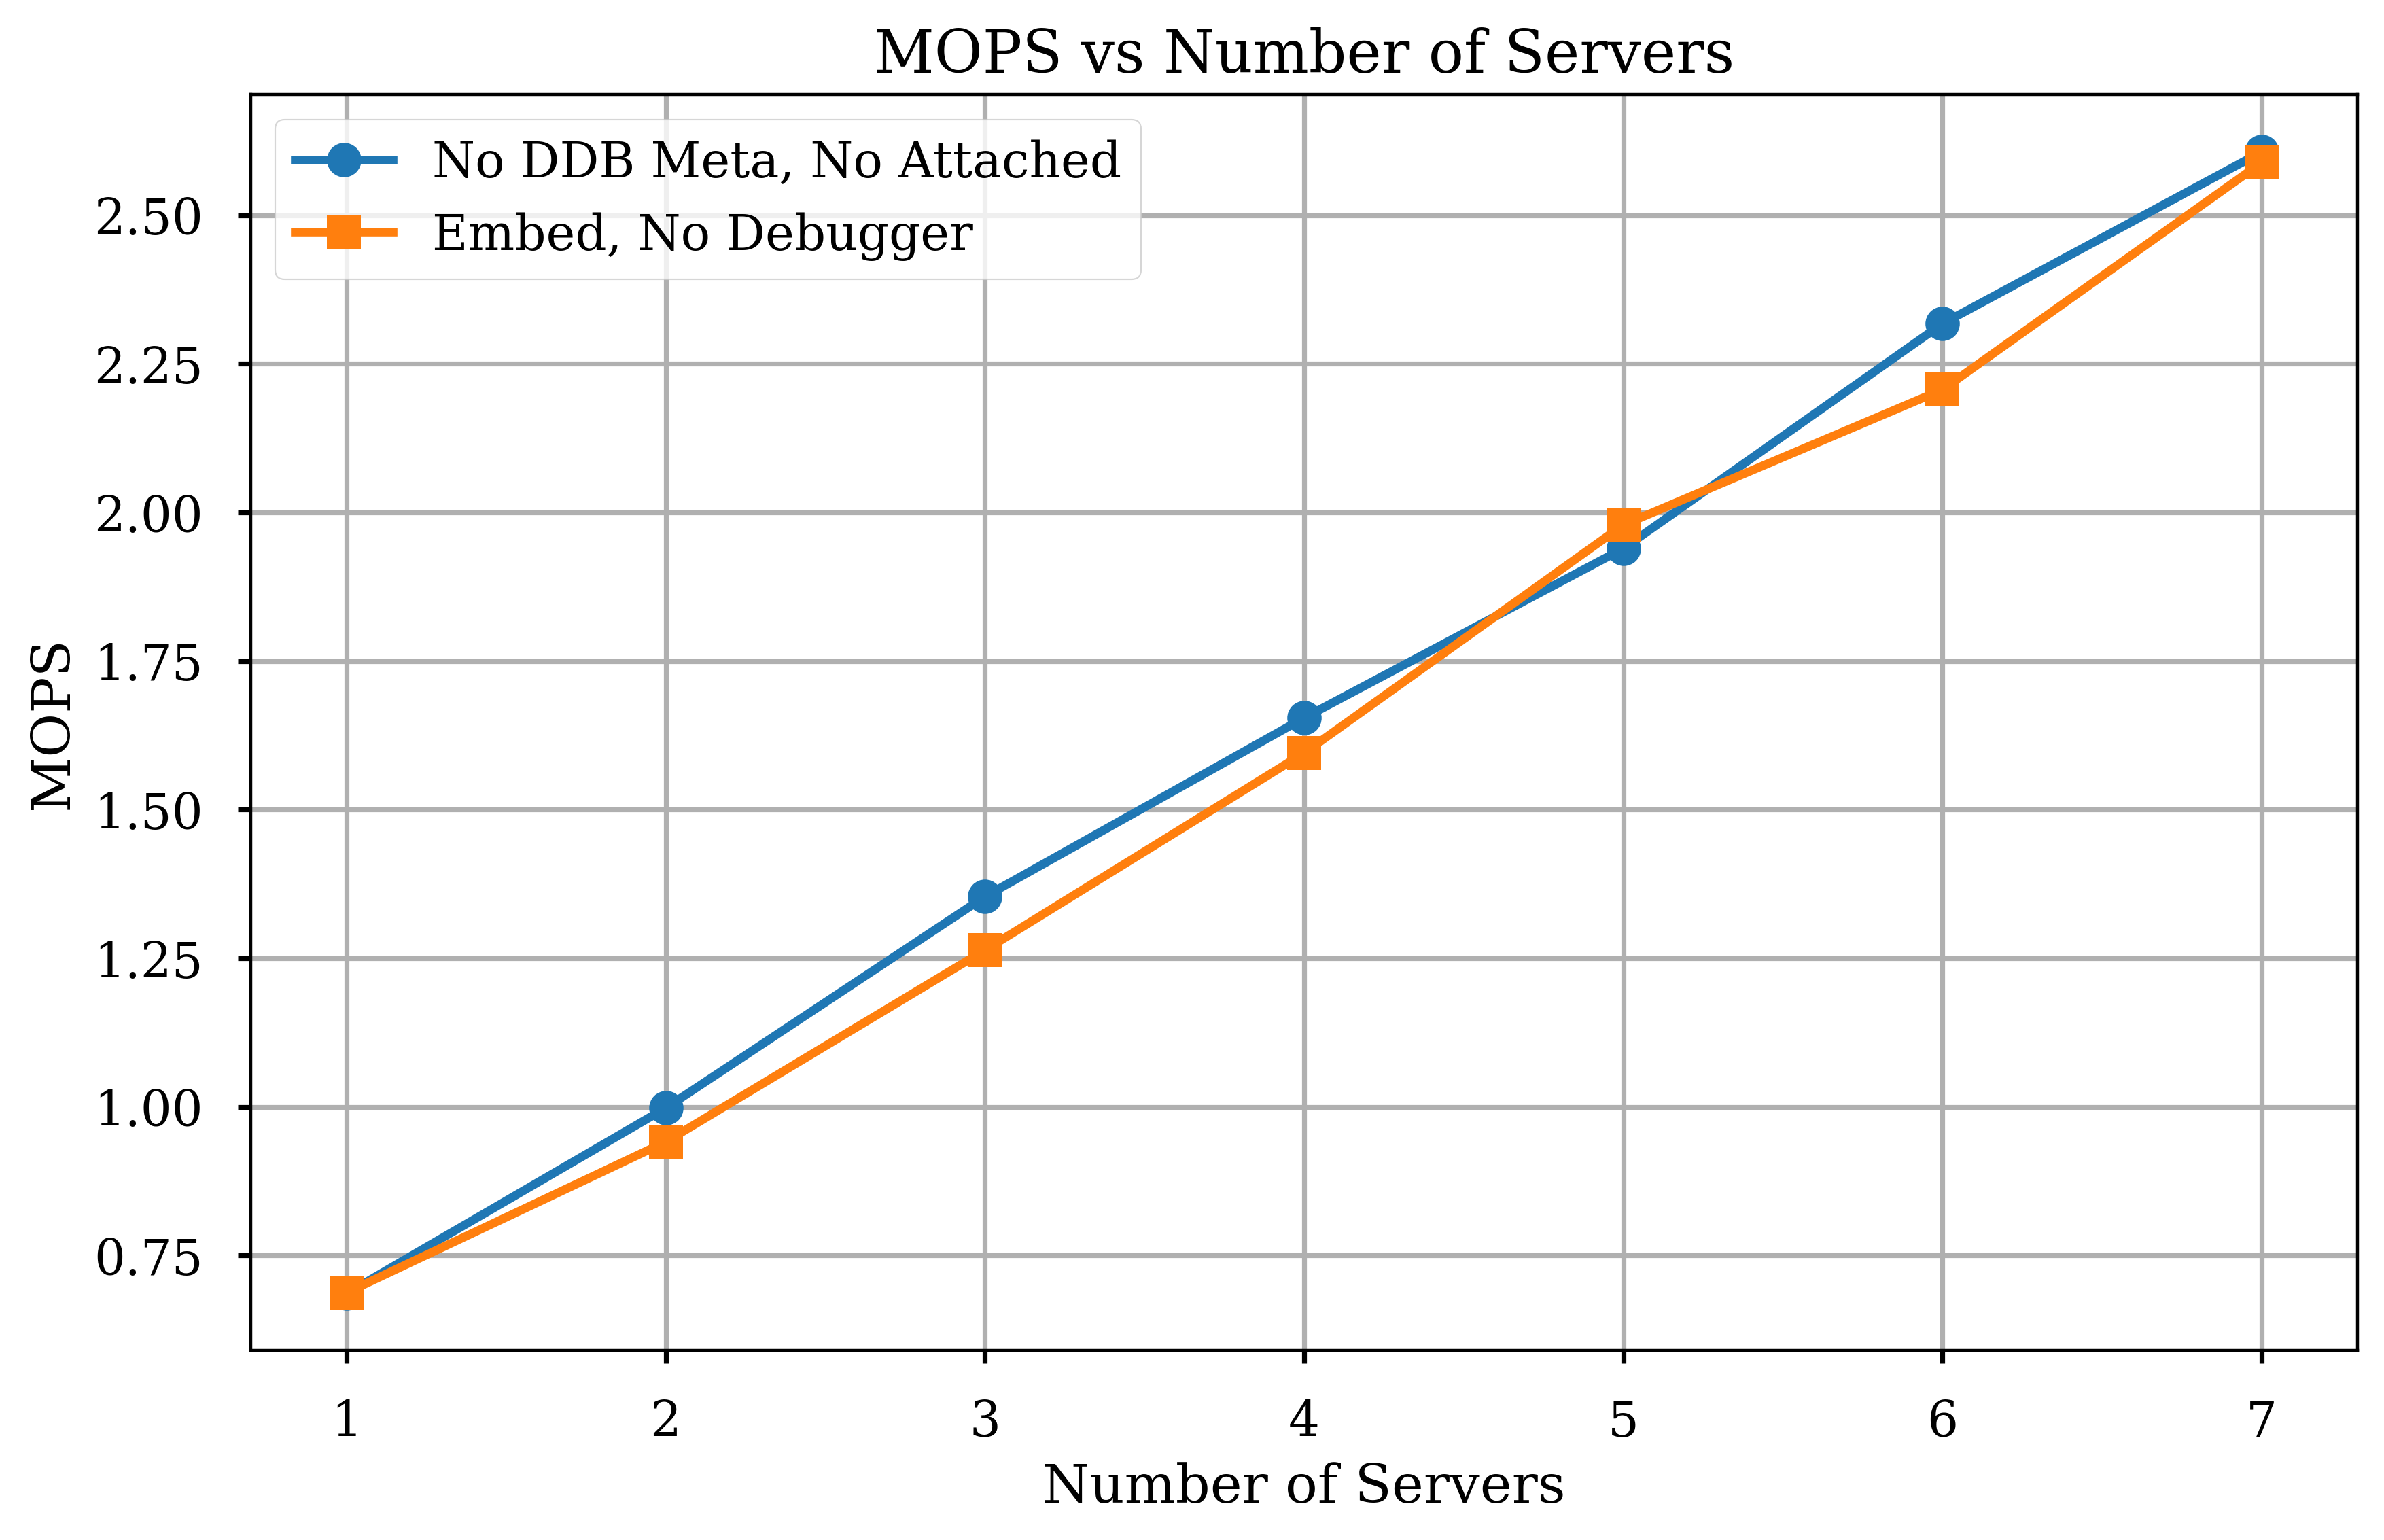

In [44]:
# plt.style.use('fivethirtyeight')
# plt.style.use('default')

plt.figure(figsize=(10, 6))
# plt.figure(figsize=(12, 6))

# Plot for embed == False and debugger == "none"
filtered_df = df.query('embed == False and debugger == "none"')
plt.plot(filtered_df['servers'], filtered_df['mops'], label='No DDB Meta, No Attached', marker='o')
# plt.scatter(filtered_df['servers'], filtered_df['mops'], marker='o')

# filtered_df = df.query('embed == False and debugger == "gdb"')
# plt.plot(filtered_df['servers'], filtered_df['mops'], label='No DDB Meta, GDB Attached', marker='^')

# Plot for embed == True and debugger == "none"
filtered_df = df.query('embed == True and debugger == "none"')
plt.plot(filtered_df['servers'], filtered_df['mops'], label='Embed, No Debugger', marker='s')
# plt.scatter(filtered_df['servers'], filtered_df['mops'], marker='s')


# filtered_df = df.query('embed == True and debugger == "ddb"')
# plt.plot(filtered_df['servers'], filtered_df['mops'], label='Embed, DDB Debugger', marker='d')


plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.legend()
plt.grid(True)
plt.show()

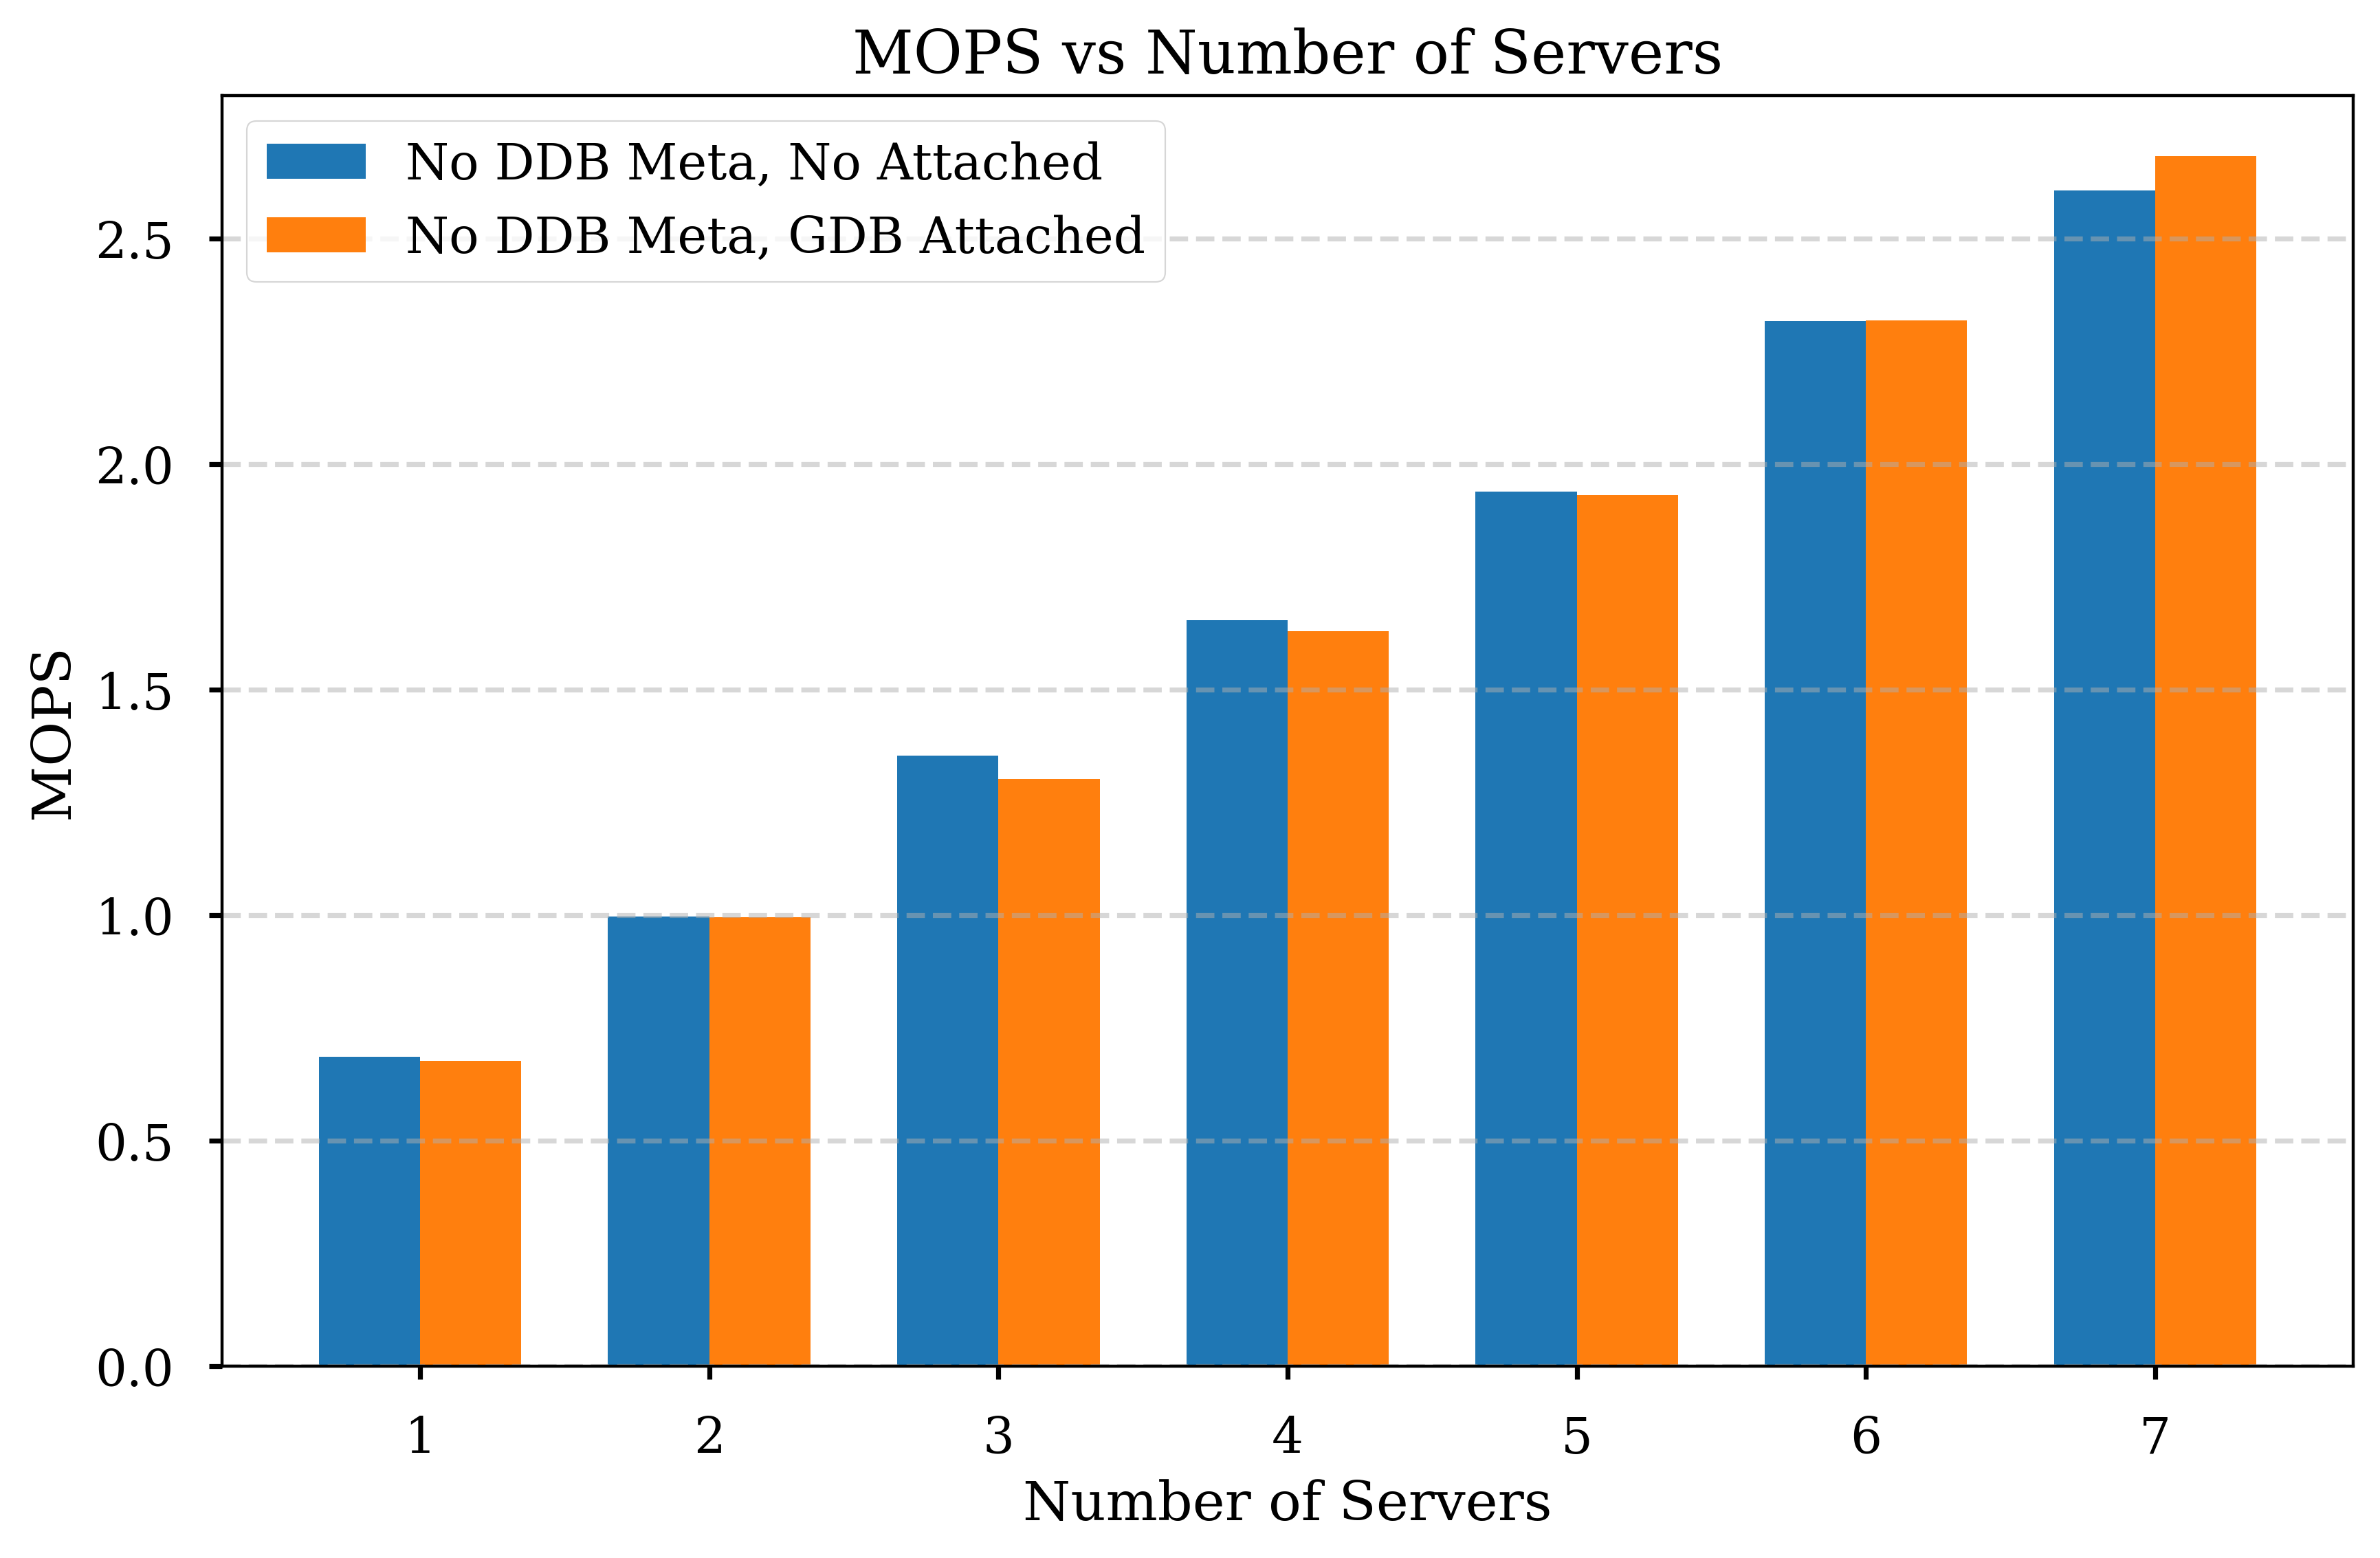

In [42]:
plt.figure(figsize=(10, 6))

# Define the width of the bars
bar_width = 0.35

# Plot for embed == False and debugger == "none"
filtered_df_none = df.query('embed == False and debugger == "none"')
plt.bar(filtered_df_none['servers'] - bar_width/2, filtered_df_none['mops'], width=bar_width, label='No DDB Meta, No Attached')

# Plot for embed == False and debugger == "gdb"
filtered_df_gdb = df.query('embed == False and debugger == "gdb"')
plt.bar(filtered_df_gdb['servers'] + bar_width/2, filtered_df_gdb['mops'], width=bar_width, label='No DDB Meta, GDB Attached')

plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.grid(False)
plt.show()
